In [1]:
## Glotaran 2: a multi-way data analysis framework for global and target analysis in Python

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from glotaran.plotting.glotaran_color_codes import get_glotaran_default_colors_cycler
from cycler import cycler

from glotaran.dataio.wavelength_time_explicit_file import ExplicitFile
from glotaran.specification_parser import parse_yml

doGlobalAnalyis = True;

In [3]:
THIS_DIR = os.path.realpath('.')
root_data_path = os.path.join(THIS_DIR, 'resources', 'data')
datapath_PAL_open = os.path.join(root_data_path, 'PAL_700_ma_tr2_gain50_10uW_590nmfilter_21C_400nm_AV_bc_sh_sel_620_830.ascii')
datapath_PAL_closed = os.path.join(root_data_path, 'PAL_DCMU_80uM_WL_SF_700_ma_tr2_gain50_100uW_590nmfilter_21C_400nm_AV_bc_sh_sel_620_830.ascii')
print(datapath_PAL_open)
print(datapath_PAL_closed)
prop_cycle=get_glotaran_default_colors_cycler()

# Read in data from resources/data sub-folder
# Dataset1
datafile_PAL_open = ExplicitFile(datapath_PAL_open)
dataset_PAL_open = datafile_PAL_open.read("dataset_PAL_open")
# Dataset2
datafile_PAL_closed = ExplicitFile(datapath_PAL_closed)
dataset_PAL_closed = datafile_PAL_closed.read("dataset_PAL_closed")

times1 = dataset_PAL_open.get_axis("time")
times2 = dataset_PAL_closed.get_axis("time")
wavelengths1 = dataset_PAL_open.get_axis("spectral")
wavelengths2 = dataset_PAL_closed.get_axis("spectral")

/vagrant/examples/resources/data/PAL_700_ma_tr2_gain50_10uW_590nmfilter_21C_400nm_AV_bc_sh_sel_620_830.ascii
/vagrant/examples/resources/data/PAL_DCMU_80uM_WL_SF_700_ma_tr2_gain50_100uW_590nmfilter_21C_400nm_AV_bc_sh_sel_620_830.ascii


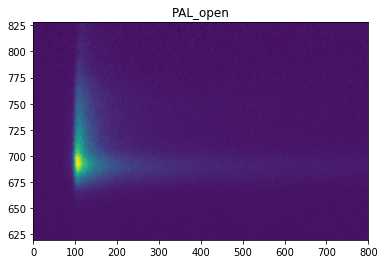

In [4]:
plt.figure()
plt.title('PAL_open')
plt.pcolormesh(times1, wavelengths1, dataset_PAL_open.data)

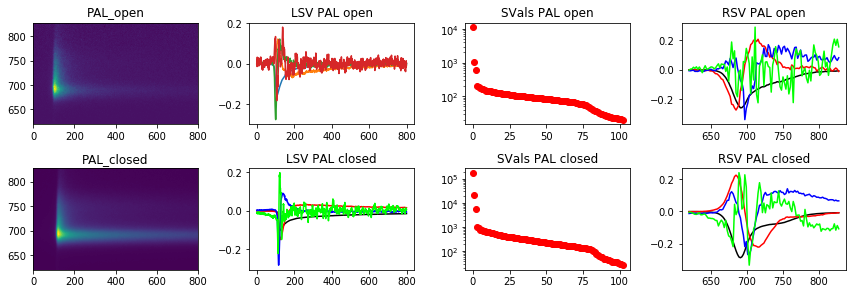

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(4, 4, 1)
plt.title('PAL_open')
plt.pcolormesh(times1, wavelengths1, dataset_PAL_open.data)
plt.subplot(4, 4, 5)
plt.title('PAL_closed')
plt.pcolormesh(times2, wavelengths2, dataset_PAL_closed.data)

rsvd1, svals1, lsvd1 = np.linalg.svd(dataset_PAL_open.data)
rsvd2, svals2, lsvd2 = np.linalg.svd(dataset_PAL_closed.data)
plt.subplot(4, 4, 2)
plt.title('LSV PAL open')
plt.rc('axes', prop_cycle=get_glotaran_default_colors_cycler())  # unsure why this is not working
for i in range(4):
    plt.plot(times1, lsvd1[i, :])
plt.subplot(4, 4, 6)
plt.title('LSV PAL closed')
plt.rc('axes', prop_cycle=get_glotaran_default_colors_cycler())  # because here it works
for i in range(4):
    plt.plot(times2, lsvd2[i, :])
# Plot singular values (SV)
plt.subplot(4, 4, 3)
plt.title('SVals PAL open')
plt.plot(range(max(10, min(len(times1), len(wavelengths1)))), svals1, 'ro')
plt.yscale('log')
plt.subplot(4, 4, 7)
plt.title('SVals PAL closed')
plt.plot(range(max(10, min(len(times2), len(wavelengths2)))), svals2, 'ro')
plt.yscale('log')
# Plot right singular vectors (RSV, wavelengths, first 3)
plt.subplot(4, 4, 4)
plt.title('RSV PAL open')
plt.rc('axes', prop_cycle=get_glotaran_default_colors_cycler())
for i in range(4):
    plt.plot(wavelengths1, rsvd1[:, i])
plt.subplot(4, 4, 8)
plt.title('RSV PAL closed')
plt.rc('axes', prop_cycle=get_glotaran_default_colors_cycler())
for i in range(4):
    plt.plot(wavelengths2, rsvd2[:, i])

plt.tight_layout()
plt.show()

In [6]:
fitspec1 = '''
type: kinetic

parameters: 
 - [1, {{vary: false}}]
 - [0, {{vary: false}}]
 - [0, {{vary: false}}]
 - [0, {{vary: false}}]
 - 101
 - 4.5
 - 0.3
 - 0.04
 - 0.01
 - 0.002

irf:
  - label: irf
    type: gaussian
    center: 5
    width: 6

compartments: [s1, s2, s3, s4]

megacomplexes:
    - label: mc1
      k_matrices: [k1]

k_matrices:
  - label: "k1"
    matrix: {{
      '("s2","s1")': 7,
      '("s3","s2")': 8,
      '("s4","s3")': 9,
      '("s4","s4")': 10
    }}

initial_concentration: #equal to the total number of compartments
  - label: inputD1
    parameter: [1, 2, 3, 4] 

datasets:
  - label: {}
    type: spectral
    initial_concentration: inputD1
    megacomplexes: [mc1]
    path: ''
    irf: irf

'''

specfit_model1 = parse_yml(fitspec1.format('dataset1'))
specfit_model1.datasets['dataset1'].data = dataset_PAL_open

In [7]:
if doGlobalAnalyis:

    specfit_result1 = specfit_model1.fit()
    specfit_result1.best_fit_parameter.pretty_print()
    residual1 = specfit_result1.final_residual()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2022e+05                                    3.08e+07    
       1              2         5.0428e+05      1.16e+05       9.23e-01       1.11e+07    
       2              3         4.9978e+05      4.50e+03       1.29e-01       3.33e+06    
       3              4         4.9931e+05      4.70e+02       1.22e-02       7.52e+05    
       4              5         4.9926e+05      4.79e+01       1.01e-02       1.62e+05    
       5              6         4.9926e+05      4.42e+00       5.57e-03       3.77e+04    
       6              7         4.9926e+05      5.62e-01       2.31e-03       1.27e+04    
       7              8         4.9926e+05      7.49e-02       9.26e-04       4.59e+03    
       8              9         4.9926e+05      1.00e-02       3.58e-04       1.68e+03    
       9             10         4.9926e+05      1.34e-03       1.35e-04       6.12e+02    

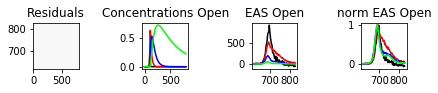

In [8]:
if doGlobalAnalyis:

    plt.subplot(4, 4, 9)
    levels = np.linspace(0, max(dataset_PAL_open.data.flatten()), 10)
    cnt = plt.contourf(times1, wavelengths1, residual1, levels=levels, cmap="Greys")
    # This is the fix for the white lines between contour levels
    for c in cnt.collections:
        c.set_edgecolor("face")
    plt.title('Residuals')

    concentrations = specfit_result1.c_matrix('dataset1')
    plt.subplot(4, 4, 10)
    plt.title('Concentrations Open')
    plt.rc('axes', prop_cycle=get_glotaran_default_colors_cycler())
    plt.plot(times1, concentrations[0])

    spectra = specfit_result1.e_matrix('dataset1')
    plt.subplot(4, 4, 11)
    plt.title('EAS Open')
    plt.axhline(0, color='gray', linewidth=0.2)
    # plt.axvline(0, color='gray')
    plt.rc('axes', prop_cycle=get_glotaran_default_colors_cycler())
    for i in range(spectra.shape[1]):
        plt.plot(wavelengths1, spectra[:, i])
    plt.subplot(4, 4, 12)
    plt.title('norm EAS Open')
    plt.axhline(0, color='gray', linewidth=0.2)
    plt.rc('axes', prop_cycle=get_glotaran_default_colors_cycler())
    for i in range(spectra.shape[1]):
        scale = max(max(spectra[:, i]), abs(min(spectra[:, i])))
        plt.plot(wavelengths1, spectra[:, i] / scale)

    plt.tight_layout()
    plt.show(block=False)